- [ ] Import data
- [ ] Make into binary, based on a threshold
- [ ] Find the brighest row and column, i.e. the galaxu of our pixture. Might be able to use blob from skimage
- [ ] Rotate using some sort of PC(A?) to make it easier for our model to handle later. 
- [ ] Resise somewhere along this list to a format we choose. 

# preprocesing
- [ ] Check each image and check how many "blobs" they have. 
- [ ] Remove them 
- [ ] Check how many we have left.  

# Remove images where blob overlap 
- [ ] Check the rows we get in blob
- [ ] Using the middle point and a radius, if two blobs overlap
- [ ] We remove that image. 

In [1005]:
%matplotlib inline

In [1006]:
import skimage as ski
import numpy as np
import sys
import matplotlib.pyplot as plt

In [1007]:
# img = ski.io.imread("/data/notebook_files/train_folder5/732123.jpg")
# img = ski.io.imread("/data/notebook_files/train_folder5/747207.jpg")
# img = ski.io.imread("/data/notebook_files/train_folder2/262909.jpg")
# img = ski.io.imread("/data/notebook_files/train_folder2/312941.jpg") ##outlier, don't change
# img = ski.io.imread("/data/notebook_files/train_folder5/732356.jpg")
# img = ski.io.imread("images_training_rev1/101151.jpg") ##irregular
# img = ski.io.imread("/data/notebook_files/test_folder5/458590.jpg") ## long
# img = ski.io.imread("images_training_rev1/459014.jpg") ##overlap
# img = ski.io.imread("images_training_rev1/100295.jpg") ##black stripe
# img = ski.io.imread("images_training_rev1/100774.jpg") ##Ovelap
img = ski.io.imread("images_training_rev1/100008.jpg")


In [1008]:
# print("Hello")
# raise SystemExit
# image_collection = ski.io.imread_collection('/images_training_rev1/*.jpg', conserve_memory=True)
# print("This should not run")

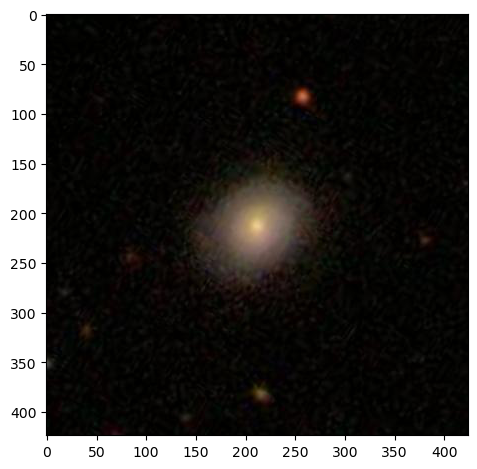

In [1009]:
ski.io.imshow(img)

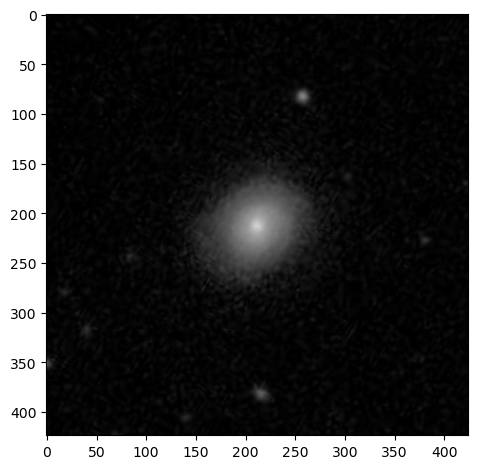

In [1010]:
# Ignores colours, as that is mostly a factor of length and the shape of the galaxy is what we are aiming for. 
gray_img = ski.color.rgb2gray(img)
ski.io.imshow(gray_img)

In [1011]:
class Galaxy:
    def __init__(self, x, y, sigma):
        self._x = x
        self._y = y
        self._sigma = sigma
    
    @property
    def center(self):
        return [self._x, self._y]
    
    @property
    def radius(self):
        factor = np.sqrt(2)
        return factor*self._sigma


def overlap(galaxy1:Galaxy, galaxy2:Galaxy):
    in_between_distance = np.sqrt((galaxy1.center[0]-galaxy2.center[0])**2 + (galaxy1.center[1]-galaxy2.center[1])**2)
    if galaxy1.radius > in_between_distance:
        return True
    else:
        return False

def find_galaxy(image, window, verbose=False):
    blobs = ski.feature.blob_doh(image, 
                                 threshold=0.001, 
                                 max_sigma = 100,
                                 num_sigma=50)
    if verbose:
        print(blobs)
    image_center = [image.shape[0]//2, image.shape[1]//2]
    found_galaxy = None
    largest_sigma = 0
    for b in blobs:
        if all(abs(b[i] - image_center[i]) < window for i in range(2)) and b[2] > largest_sigma:
            print(f"blob considered: {b[0]}, {b[1]}, {b[2]}")
            largest_sigma = b[2]
            found_galaxy = b

    found_galaxy = Galaxy(found_galaxy[0], found_galaxy[1], found_galaxy[2])

    for b in blobs:
        blob = Galaxy(b[0], b[1], b[2])
        if blob.center != found_galaxy.center:
            # Check if they overlap
            if overlap(found_galaxy, blob):
                if verbose:
                    print(f"There is overlap. x1={blob.center[0]}, y1={blob.center[1]}")
                return found_galaxy #REMOVE!
    return found_galaxy
            

In [1012]:

galaxy = find_galaxy(gray_img, window=50, verbose=True)

[[211.         212.          49.48979592]
 [ 82.         256.           7.06122449]
 [381.         215.           9.08163265]
 [351.           0.           5.04081633]]
blob considered: 211.0, 212.0, 49.48979591836734


In [1013]:
def check_for_black_stripe(image):
    # If there is at least 10 dark pixels in a row of any angle that are surrounded by light pixels, then there is a black stripe
    # image is cropped and gray scaled

    dark_pixel_threshold = 0.1
    dark_pixel_count_threshold = 10
    bright_pixel_threshold = 0.2

    dark_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] < dark_pixel_threshold:
                dark_pixels.append([i,j])
    
    bright_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] > bright_pixel_threshold:
                bright_pixels.append([i,j])


    suspicious_pixels = []
    # Look at a window around each dark pixel
    # If the mean of the pixels in the window is above the bright pixel threshold, add it to the list of suspicious pixels
    for pixel in dark_pixels:
        window = 5
        window_pixels = []
        for i in range(pixel[0]-window, pixel[0]+window):
            for j in range(pixel[1]-window, pixel[1]+window):
                if i >= 0 and i < image.shape[0] and j >= 0 and j < image.shape[1]:
                    window_pixels.append(image[i][j])
        if np.mean(window_pixels) > bright_pixel_threshold:
            suspicious_pixels.append(pixel)

    # Plot the suspicious pixels onto the image

    #Plot the dark pixels onto the image
    ski.io.imshow(image)
    
    for pixel in bright_pixels:
        plt.plot(pixel[1], pixel[0], 'bo')
    for pixel in dark_pixels:
        plt.plot(pixel[1], pixel[0], 'ro')
    for pixel in suspicious_pixels:
        plt.plot(pixel[1], pixel[0], 'go')
    plt.show()

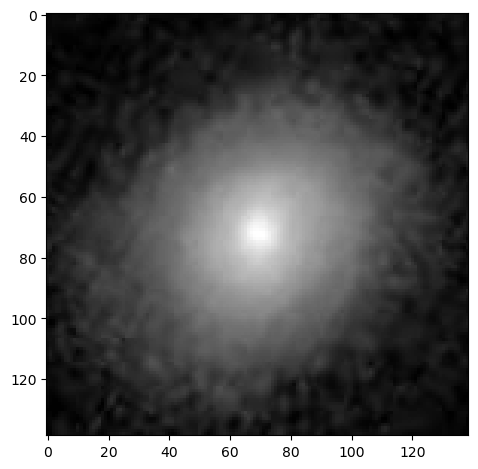

In [1014]:
def cropp_image(image, center_x, center_y, radius):
    return image[int(center_x-radius):int(center_x+radius), int(center_y-radius):int(center_y+radius)]


cropped_img = cropp_image(gray_img, galaxy.center[0], galaxy.center[1], galaxy.radius)
cropped_exposed_img = ski.exposure.rescale_intensity(cropped_img)
ski.io.imshow(cropped_exposed_img)


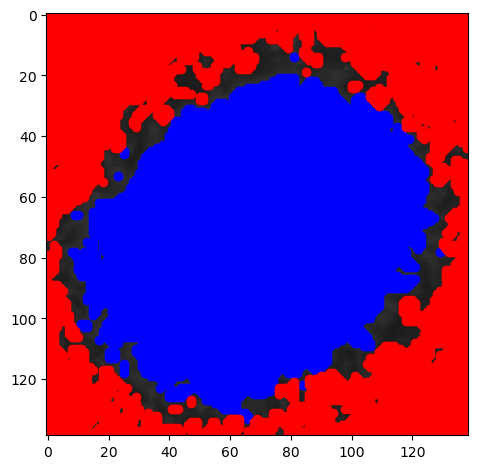

In [1015]:
check_for_black_stripe(cropped_exposed_img)

In [1016]:
def get_covariance_matrix(image, x_size, y_size):
    coord_rows = []
    coord_columns = []
    for index_row in range(0, x_size):
        for index_column in range(0, y_size):
            if image[index_row][index_column] == 1:
                coord_rows.append(index_row)
                coord_columns.append(index_column)
    cov_matrix = np.cov(coord_rows, y=coord_columns)
    return cov_matrix


cov_matrix[0] = 	[173.034594678127, -33.29514924277873]
cov_matrix[1] = 	[-33.29514924277873, 177.52601021830003]
Eigenvalues     = 	[141.909504338376, 208.65110055805104]
eigenvectors[0] = 	[-0.7305120110812446, -0.6828998474637664]
eigenvectors[1] = 	[-0.6828998474637664, 0.7305120110812446]
-0.6828998474637664
-0.6828998474637664
Rotating images with the deg 46.929334936334044


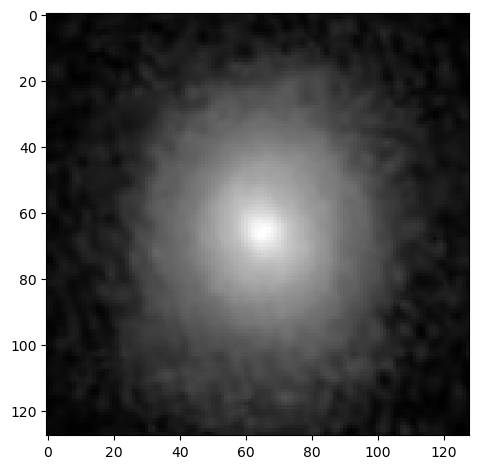

In [1017]:
def get_rotation_on_image(image, verbose=False):
    binary_image = ski.util.img_as_bool(image)
    if verbose:
        ski.io.imshow(binary_image)
        pass
    
    cov_matrix = get_covariance_matrix(binary_image, len(binary_image), len(binary_image[0]))
    
    if verbose:
        print(f"cov_matrix[0] = \t[{cov_matrix[0][0]}, {cov_matrix[0][1]}]")
        print(f"cov_matrix[1] = \t[{cov_matrix[1][0]}, {cov_matrix[1][1]}]")
    result = np.linalg.eigh(cov_matrix)
    eigenvalues = result[0]
    eigenvectors = result[1]

    
    max_eigen_index, = np.where(np.isclose(eigenvalues, max(eigenvalues)))[0]
    if verbose:
        print(f"Eigenvalues     = \t[{eigenvalues[0]}, {eigenvalues[1]}]")
        print(f"eigenvectors[0] = \t[{eigenvectors[0][0]}, {eigenvectors[0][1]}]")
        print(f"eigenvectors[1] = \t[{eigenvectors[1][0]}, {eigenvectors[1][1]}]")
        print(eigenvectors[max_eigen_index][0])
        print(eigenvectors[(max_eigen_index+1)%2][1])
    rotations_in_radians = np.arccos((eigenvectors[max_eigen_index][0]+eigenvectors[(max_eigen_index+1)%2][1]) / 2)
    rotation_in_degrees = np.rad2deg(rotations_in_radians)
    if rotation_in_degrees > 90:
        rotation_in_degrees = 180 - rotation_in_degrees


    if (eigenvectors[max_eigen_index][0] * eigenvectors[max_eigen_index][1]) > 0:
        rotation_in_degrees = -rotation_in_degrees

    if verbose:
        print("Rotating images with the deg", rotation_in_degrees)
        # ski.io.imshow(ski.transform.rotate(image, rotation_in_degrees))

    return rotation_in_degrees

angle = get_rotation_on_image(cropped_exposed_img, verbose=True)
rotated_image = ski.transform.rotate(gray_img, angle)
cropped_rotated_img = cropp_image(rotated_image, galaxy.center[0], galaxy.center[1], galaxy.radius)
resized_cropped_rotated_image = ski.transform.resize(cropped_rotated_img, (128, 128))
resized_cropped_rotated_image = ski.exposure.rescale_intensity(resized_cropped_rotated_image)
ski.io.imshow(resized_cropped_rotated_image)

In [1018]:
print("Hello")
raise SystemExit
print("This should not run")

Hello


SystemExit: 